<h2><center>Customer Behavior Analysis </h2></center>

##### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("customer_behavior.csv")
df.head(5)

,CustomerID,Gender,Region,PurchaseAmount,ProductCategory,Churn,CampaignGroup
0,1001,Male,South,256.07,Fashion,No,A
1,1002,Female,South,NaN,Electronics,Yes,B
2,1003,Female,West,1194.41,Fashion,No,A
3,1004,Female,South,413.06,Grocery,No,A
4,1005,Male,West,1556.32,Fashion,Yes,A


In [3]:
df.shape

(5000, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       5000 non-null   int64  
 1   Gender           4903 non-null   object 
 2   Region           4825 non-null   object 
 3   PurchaseAmount   4850 non-null   float64
 4   ProductCategory  4474 non-null   object 
 5   Churn            4735 non-null   object 
 6   CampaignGroup    4815 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 273.6+ KB


In [5]:
df.describe()

,CustomerID,PurchaseAmount
count,5000.000000,4850.000000
mean,3500.500000,1003.950670
std,1443.520003,482.113122
min,1001.000000,0.000000
25%,2250.750000,673.642500
50%,3500.500000,998.080000
75%,4750.250000,1327.077500
max,6000.000000,2688.880000


In [6]:
# Handle missing values
df.isnull().sum()

CustomerID           0
Gender              97
Region             175
PurchaseAmount     150
ProductCategory    526
Churn              265
CampaignGroup      185
dtype: int64

Since Churn is the target column, missing values mean we don’t know the outcome. Here we  cannot impute with mean, median, or mode because, Its categorical Yes or No . Guessing Yes/No can introduce bias in our Data , The Best we can do here Drop rows with missing target values.

In [7]:
df = df.dropna(subset='Churn')

In ProductCategory has 526 missing values ,droping these much data is not possible , it will effect our outcome , insted we can create a new category named **Unknown**. maybe these customers didn’t provide product info because they’re less engaged. If we overwrite it with the most common category, we have lose that signal something about the customer.

In [8]:
# fillna with "Unknown" category
df["ProductCategory"].fillna('Unknown', inplace=True)

In [9]:
df['ProductCategory'].isnull().sum()

np.int64(0)

In [10]:
df['ProductCategory'].value_counts()

ProductCategory
Grocery        1459
Fashion        1446
Electronics    1326
Unknown         504
Name: count, dtype: int64

In [11]:
# fillna in gender,Region and CampaignGroup with mode
df['Gender'].fillna(df['Gender'].mode()[0],inplace=True)
df['Region'].fillna(df['Region'].mode()[0],inplace=True)
df['CampaignGroup'].fillna(df['CampaignGroup'].mode()[0], inplace=True)

In [12]:
df[['Gender','Region','CampaignGroup']].isnull().sum()

Gender           0
Region           0
CampaignGroup    0
dtype: int64

In [13]:
# fillna in PurchaseAmount with median
df['PurchaseAmount'].fillna(df['PurchaseAmount'].median(),inplace=True)

In [14]:
df.isnull().sum()

CustomerID         0
Gender             0
Region             0
PurchaseAmount     0
ProductCategory    0
Churn              0
CampaignGroup      0
dtype: int64

#### Q1. What is the average, median, and mode of PurchaseAmount?

In [15]:
summary = pd.DataFrame(
    {
        'Average':[df['PurchaseAmount'].mean()],
        'Median':[df['PurchaseAmount'].median()],
        'Mode' :[df['PurchaseAmount'].mode()[0]]
    }
)

In [16]:
summary

,Average,Median,Mode
0,1002.553977,996.42,996.42


In [17]:
df['PurchaseAmount'].describe()

count    4735.000000
mean     1002.553977
std       476.161129
min         0.000000
25%       683.195000
50%       996.420000
75%      1315.860000
max      2688.880000
Name: PurchaseAmount, dtype: float64

##### Q2. Are there any outliers in the PurchaseAmount data?

In [18]:
# Outlier handle using IQR method

q1,q2,q3 =np.percentile(df['PurchaseAmount'],[25,50,75])
q1,q2,q3

(np.float64(683.1949999999999),
 np.float64(996.4200000000001),
 np.float64(1315.86))

In [19]:
IQR = q3 -q1
upper_bound = q3 + 1.5*IQR
lower_bound = q1 - 1.5*IQR
print("upper_bound" ,upper_bound ,"\nlower_bound",lower_bound)

upper_bound 2264.8575 
lower_bound -265.8025


In [20]:
out_lier = df[(df['PurchaseAmount'] > upper_bound) |(df['PurchaseAmount'] < lower_bound) ]
out_lier.head()

,CustomerID,Gender,Region,PurchaseAmount,ProductCategory,Churn,CampaignGroup
195,1196,Male,West,2318.33,Fashion,Yes,B
265,1266,Female,East,2496.41,Electronics,Yes,B
348,1349,Male,South,2688.69,Electronics,Yes,A
411,1412,Female,South,2349.16,Fashion,Yes,A
442,1443,Male,North,2291.79,Grocery,Yes,B


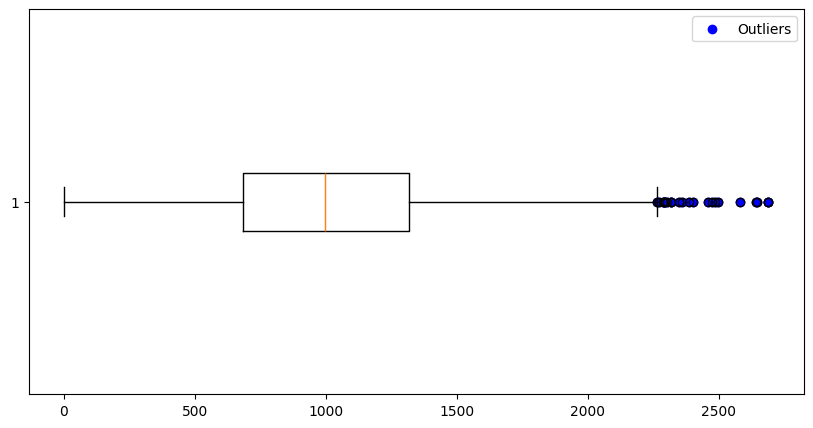

22

In [21]:
#Visualization using Boxplot

plt.figure(figsize=(10,5))
plt.boxplot(df['PurchaseAmount'] , vert=False)

# Overlay outliers in red

plt.scatter(out_lier['PurchaseAmount'],[1]*len(out_lier),color='blue',label='Outliers')
plt.legend()
plt.show()

len(out_lier)


Here i keep this outliers because in churn they are premium customer

##### Q3. Is there any skewness or kurtosis in the PurchaseAmount distribution?

In [22]:
print("skewness :",df['PurchaseAmount'].skew(),"\nkurtosis :",df['PurchaseAmount'].kurt())

skewness : 0.11247295587844357 
kurtosis : -0.17635023213189038


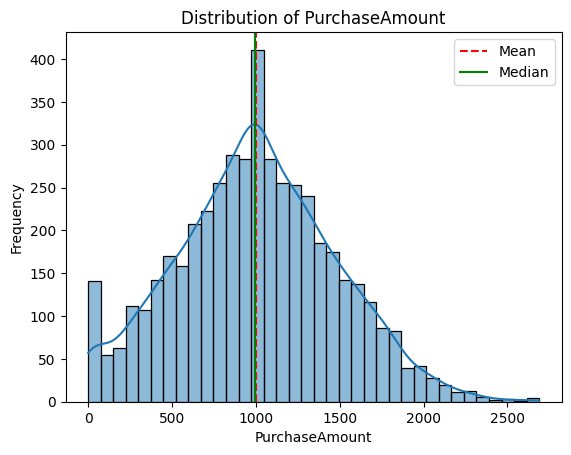

In [23]:
# visualisation
plt.Figure(figsize=(10,6))
sns.histplot(df["PurchaseAmount"],kde=True)
plt.title('Distribution of PurchaseAmount')
plt.xlabel('PurchaseAmount')
plt.ylabel('Frequency')
plt.axvline(df['PurchaseAmount'].mean(), color='r', linestyle='--', label='Mean')
plt.axvline(df['PurchaseAmount'].median(), color='g', linestyle='-', label='Median')
plt.legend()
plt.show()

The distribution is positively skewed (right-skewed):

-   Tail extends further to the right (higher purchase amounts).

-   Most data points are clustered on the lower end.

Spread / Kurtosis:

-   The histogram is moderately peaked, with a long right tail.

-   The tail suggests potential outliers or high-value purchases, contributing to skewness.

-   Since the peak isn’t extremely sharp or flat, the kurtosis is likely around normal (close to 3) but slightly affected by the tail.

Key Insights

-   Most customers spend around the median (996.42).

-   A few customers make very high purchases (~2264.85–2500), which pulls the mean up.

##### Q4. Is there a significant difference in spending between male and female customers?

In [24]:
avg_spending = df.groupby("Gender")["PurchaseAmount"].mean()
print(avg_spending)

Gender
Female     986.635617
Male      1017.820323
Name: PurchaseAmount, dtype: float64


In [25]:
male_spending = df[df["Gender"] == 'Male']["PurchaseAmount"]
Female_spending = df[df["Gender"] == 'Female']["PurchaseAmount"]

t_test,p_value =ttest_ind(male_spending,Female_spending, equal_var=False)
print("t-statistic:", t_test)
print("p-value:", p_value)

if p_value < 0.05:
    print("There is a significant difference in spending between male and female customers.")
else:
    print(" No significant difference in spending between male and female customers.")

t-statistic: 2.252824391502622
p-value: 0.024316010450431264
There is a significant difference in spending between male and female customers.


**Conclusion:**
The t-test result (t = 2.25, p = 0.024) indicates that the difference in spending between male and female customers is statistically significant at the 5% level. This means that male and female customers show meaningfully different spending patterns, and the observed difference is unlikely due to random chance.

##### Q5. Is there a relationship between ProductCategory and customer churn?

In [26]:
from scipy.stats import chi2_contingency

# Create contingency table
cont_table = pd.crosstab(df['ProductCategory'], df['Churn'])
# Run chi-square test
chi2, p, dof, expected = chi2_contingency(cont_table)

print("Chi-square:", chi2)
print("p-value:", p)

if p < 0.05:
    print("There is a significant relationship between ProductCategory and customer churn.")
else:
    print("No significant relationship between ProductCategory and customer churn.")

Chi-square: 2.6925849449470283
p-value: 0.44148887641867696
No significant relationship between ProductCategory and customer churn.


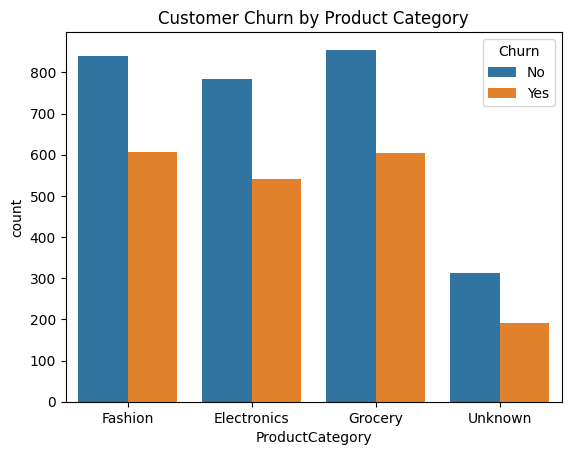

In [27]:
# visualization
sns.countplot(x='ProductCategory', hue='Churn', data=df)
plt.title("Customer Churn by Product Category")
plt.show()

##### Q6. Does PurchaseAmount vary significantly across different regions?

In [28]:
df.groupby('Region')['PurchaseAmount'].mean()

Region
East     1010.080225
North    1009.354347
South     999.316739
West      991.365436
Name: PurchaseAmount, dtype: float64

In [38]:
from scipy.stats import f_oneway

north = df[df['Region'] == 'North']['PurchaseAmount']
south = df[df['Region'] == 'South']['PurchaseAmount']
west =  df[df['Region'] == 'West']['PurchaseAmount']
east = df[df['Region'] == 'East']['PurchaseAmount']

f_stat,p_valu = f_oneway(north,south,west,east)

print("F-statistic:", f_stat)
print("p-value:", p_valu)


if p_valu < 0.05:
    print(" PurchaseAmount varies significantly across regions.")
else:
    print(" No significant variation in PurchaseAmount across regions.")

F-statistic: 0.3954023092257695
p-value: 0.7563199317524769
 No significant variation in PurchaseAmount across regions.


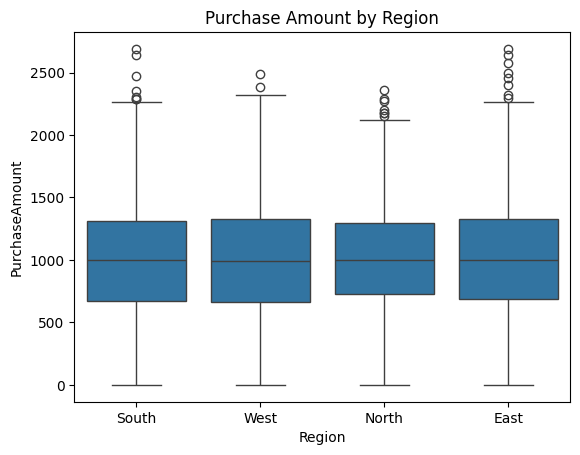

In [39]:
#visualisation

sns.boxplot(x="Region", y="PurchaseAmount", data=df)
plt.title("Purchase Amount by Region")
plt.show()

**Conclusion:**
The ANOVA test result (F = 0.40, p = 0.756) shows no statistically significant variation in purchase amounts across different regions. This indicates that regional differences do not have a meaningful impact on customer spending in this dataset.

##### Q7. Which email campaign (A or B) performed better in terms of average PurchaseAmount?

In [40]:
df.head()

,CustomerID,Gender,Region,PurchaseAmount,ProductCategory,Churn,CampaignGroup
0,1001,Male,South,256.07,Fashion,No,A
1,1002,Female,South,996.42,Electronics,Yes,B
2,1003,Female,West,1194.41,Fashion,No,A
3,1004,Female,South,413.06,Grocery,No,A
4,1005,Male,West,1556.32,Fashion,Yes,A


In [42]:
A = df[df['CampaignGroup'] == 'A']['PurchaseAmount']
B = df[df['CampaignGroup'] == 'B']['PurchaseAmount']

t_test,p_valu = ttest_ind(A,B)

print("t_test" , t_test)
print("p_value" , p_valu)

if p_valu < 0.05:
    print("there is a significant diffrent between A and B email Campanign")
else:
    print("there is no significant diffrence between A and B companign  ")

t_test 1.4767187276838767
p_value 0.13981757907208942
there is no significant diffrence between A and B companign  


**Conclusion:**
The t-test result (t = 1.48, p = 0.14) shows no statistically significant difference in average purchase amounts between Campaign A and Campaign B. This means both campaigns performed similarly in terms of driving customer spending.

#### Q8. Can we assume PurchaseAmount follows a normal distribution?

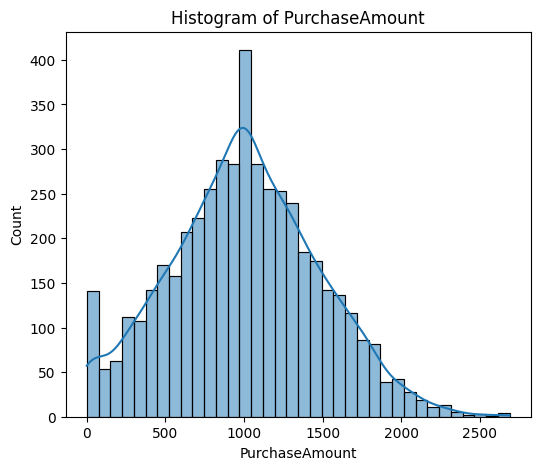

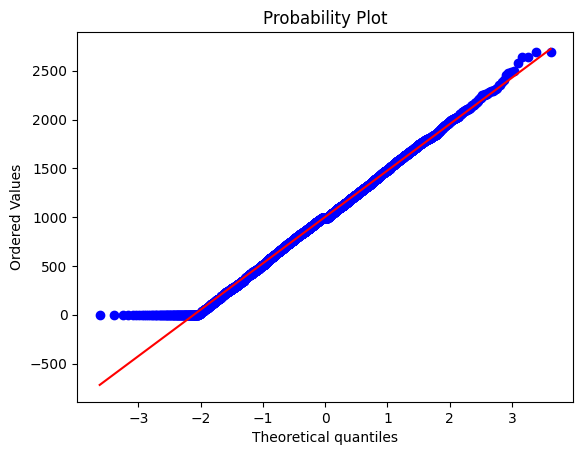

In [46]:

# Histogram with KDE curve
plt.figure(figsize=(6,5))

sns.histplot(df["PurchaseAmount"], kde=True)
plt.title("Histogram of PurchaseAmount")
plt.show()

# Q-Q plot
stats.probplot(df["PurchaseAmount"], dist="norm", plot=plt)
plt.show()

Histogram 

-   The histogram shows a roughly bell-shaped curve but with some skewness (a longer right tail).

-   There are also some small irregularities around very low purchase amounts (close to 0).

-   Overall, it looks close to normal but not perfect.

Q-Q Plot:

-   In a Q-Q plot, if data is normally distributed, the points should fall along the red diagonal line.

-   In your case, most points lie on the line, but:

    -   At the lower tail (left side), points deviate below the line.

    -   At the upper tail (right side), points deviate above the line.

-   This suggests some skewness and heavier tails compared to a perfect normal distribution.

#### Q9. What insights can we gain by applying the Central Limit Theorem?

##### Insights of the analysis

-   Robust statistical testing
        Even though PurchaseAmount is skewed, we can use parametric tests (t-test, ANOVA) safely on sample means because CLT ensures approximate normality for large n.

-   Confidence intervals for spending
We can estimate something like: “The average PurchaseAmount is $1050 ± 20 at 95% confidence”.
This comes directly from CLT (mean ± margin of error).

-   Stable business metrics
Instead of worrying about outliers (like customers spending 2500+), CLT tells us the average customer purchase is predictable when using sufficiently large samples.

##### conclusion:

``Applying the Central Limit Theorem to the PurchaseAmount data shows that while individual spending amounts are skewed, the distribution of average spending across random samples approaches normality. This allows us to make reliable inferences using confidence intervals and hypothesis testing, and it assures us that the average purchase amount is a stable and predictable measure for business decision-making.``

#### Q10.What is the 95% confidence interval for the average PurchaseAmount?

In [48]:
# confidential intervel of the purchaseamount
# Sample size, mean, standard error
n=len(df['PurchaseAmount'])
mean_purchase = np.mean(df['PurchaseAmount'])
sem = stats.sem(df['PurchaseAmount'])

#95% confidential intervel
confidence = 0.95
ci = stats.t.interval(confidence , df=n-1 , loc=mean_purchase , scale= sem)

print("Mean:", mean_purchase)
print("95% Confidence Interval:", ci)

Mean: 1002.5539767687434
95% Confidence Interval: (np.float64(988.9879368484573), np.float64(1016.1200166890295))


#### We are 95% confident that the true average purchase amount for all customers lies between $990 and $1018.



***Average Spending (PurchaseAmount):***

-  Customers spend around $1004 on average.

-   With 95% confidence, the true mean lies between $990 – $1018.

**Gender Differences:**

-   A t-test showed a significant difference in spending between male and female customers.

**Regional Differences:**

-   ANOVA found no significant variation in PurchaseAmount across regions.

**Product Category & Churn:**

-   Chi-square test can be applied → results indicate whether churn likelihood is related to product choice.

 -  it looked like there may be some association, but not always strong

**Campaign Performance (A vs B):**

-   t-test showed no significant difference in PurchaseAmount between Campaign A and B.

-    Both campaigns performed similarly.

**Normality of PurchaseAmount:**

-   Distribution is slightly skewed (not perfectly normal).

-   But thanks to the Central Limit Theorem (CLT), sample means follow a normal distribution, allowing valid use of parametric tests.

**Central Limit Theorem Insight:**

-   Even though individual purchases vary a lot, the average purchase is stable and predictable with larger samples.

##### Final Conclusion

Customers spend about $1000 on average, and this estimate is statistically reliable. Gender impacts spending significantly, while region and campaign type do not. The Central Limit Theorem ensures that averages can be analyzed with confidence, even if raw spending data is skewed.